In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt

from mavisetc.instruments import (MAVIS_IFS, MAVIS_Imager)
from mavisetc.sources import (flat_source, template_source)
from mavisetc.sky import sky_source

# Load in some sky and source models

In [2]:
###### SKY MODEL ########
#initialize the sky model, working in offline mode 
#this will just use the nearest pre-determined sky in FLI
skyModel = sky_source(offline=True)

#set sky to dark, zenith, and standard PWV
skyModel.set_params(fli=0.0, airmass=1.0, pwv=10)

##### SOURCE MODELS ######
#we'll just initialize a flat model and template model for now.
flatSource = flat_source()
templateSource = template_source()

# Spectrograph
1) Let's look at sensitivity limits for the coarse pixel scale

1 hours on source (3 x 1200s integrations), 50mas pixel scale, 3x3 spatial binning

<IPython.core.display.Javascript object>


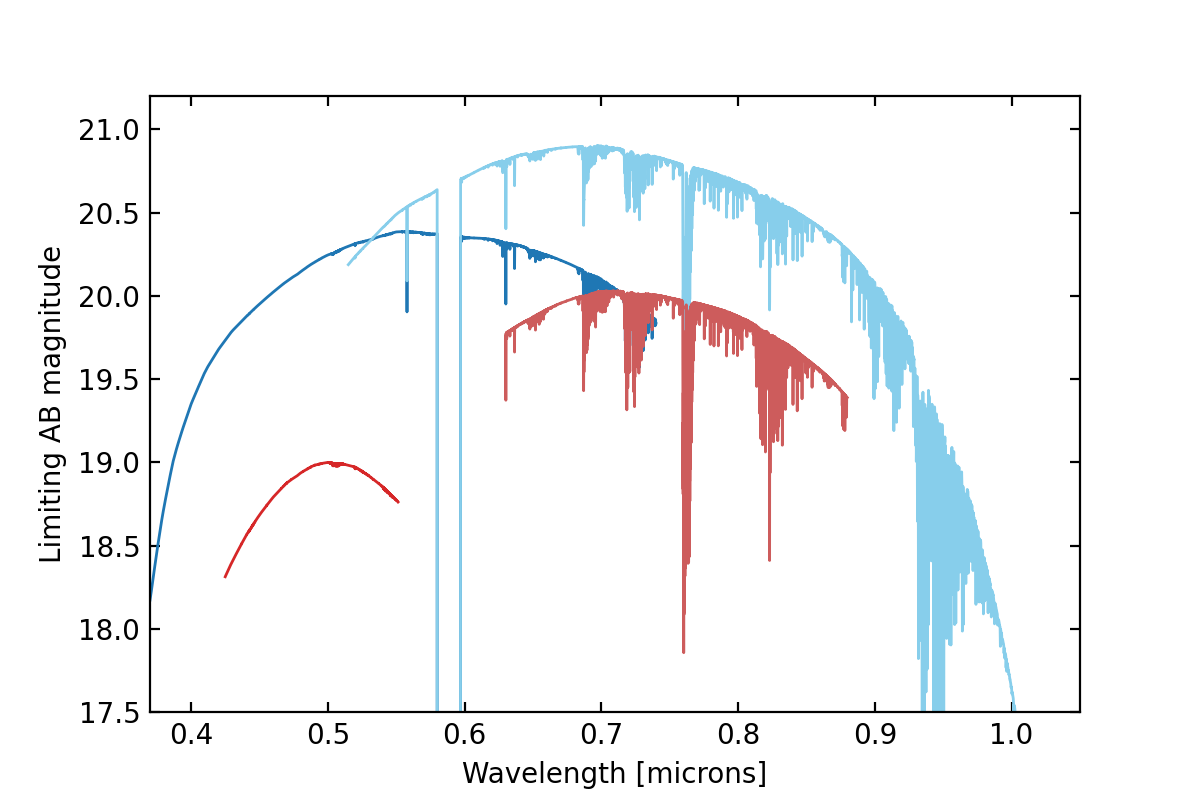

In [3]:
ndit = 3 # number of exposures
dit = 1200 # integration time per exposure

colors = ['C0', 'C3', 'skyblue', 'indianred']
labels = ['LR-blue', 'HR-blue', 'LR-red','HR-red']

#coarse spaxel scale
fig, ax = plt.subplots(figsize=(6,4))
for ii, grating in enumerate(labels):
    #initialze the MAVIS IFS with this grating mode and pixel scale
    mavis_ifs = MAVIS_IFS(mode=grating, pix_scale=0.05)
    
    #estimate the limiting magnitude for a 10 sigma point source detection, 3x3 spatial binning
    limiting_mag = mavis_ifs.get_mag_limit(sn=10, sky=skyModel, dit=dit, ndit=ndit, binning=3, norm='point')
        
    #plot it!
    ax.plot(mavis_ifs.inst_wavelength, limiting_mag, linewidth=1, color=colors[ii])

#set some sensible axis limits
plt.xlim(0.37, 1.05)
plt.ylim(17.5, 21.2)

#add some axis labels
plt.ylabel('Limiting AB magnitude')
plt.xlabel('Wavelength [microns]')
plt.show()


2) Comparison of the surface brightness sensitivity for fine and coarse spaxel scales with the low-res red grating.

1 hour on source (3 x 1200s integrations), per spatial pixel

<IPython.core.display.Javascript object>


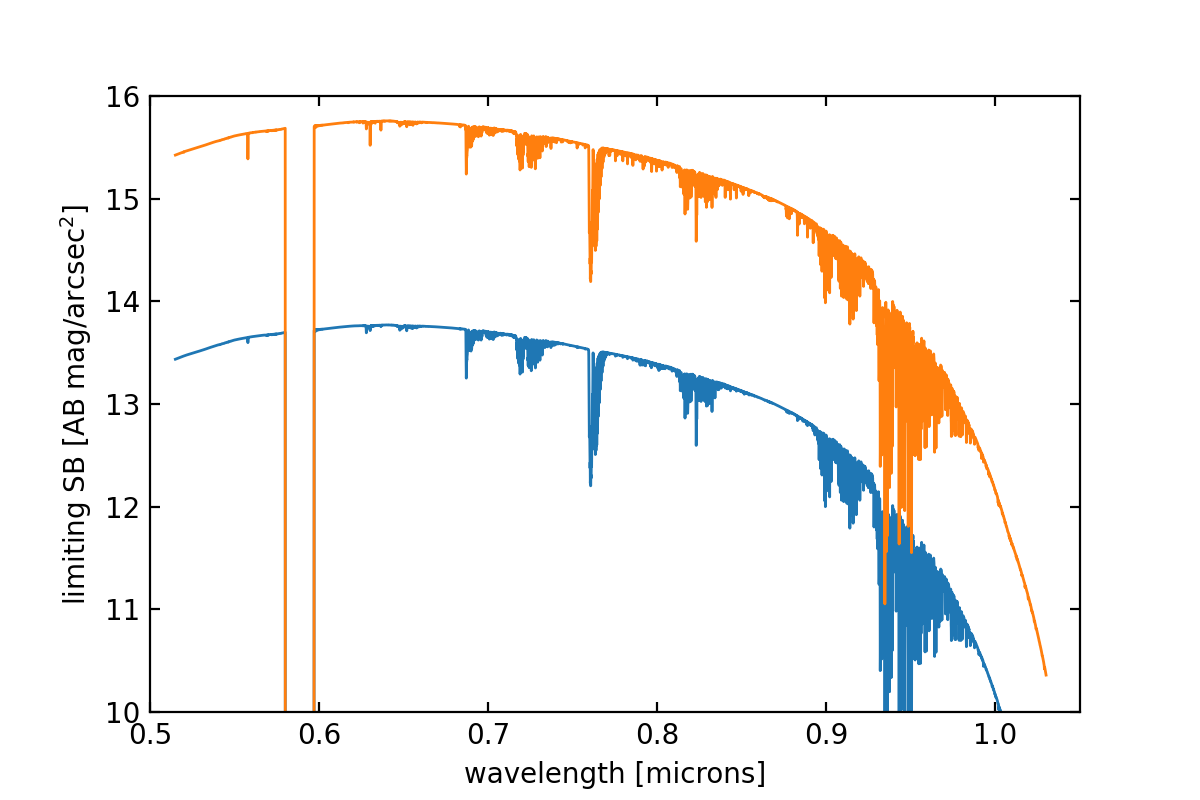

In [4]:
ndit = 3 # number of exposures
dit = 1200 # integration time per exposure

fig, ax = plt.subplots(figsize=(6,4))

for pixel_scale in [0.02,0.05]:
    mavis_ifs = MAVIS_IFS(mode='LR-red', pix_scale=pixel_scale)

    #estimate the limiting SB for a 10 sigma detection per pixel
    limiting_mag = mavis_ifs.get_mag_limit(sn=10, sky=skyModel, dit=dit, ndit=ndit, binning=1, norm='extended')
        
    #plot it!
    ax.plot(mavis_ifs.inst_wavelength, limiting_mag, linewidth=1)

#set some sensible axis limits
plt.xlim(0.5, 1.05)
plt.ylim(10, 16)

#add some axis labels
plt.ylabel('limiting SB [AB mag/arcsec$^2$]')
plt.xlabel('wavelength [microns]')
plt.show()


3) Simulated observation of star-forming galaxy at z=0.4, with an i-band surface brightness of 19.
    
low-resolution red grating, 50mas pixel scale, 4 hours on source (12 x 1200s integrations)

<IPython.core.display.Javascript object>


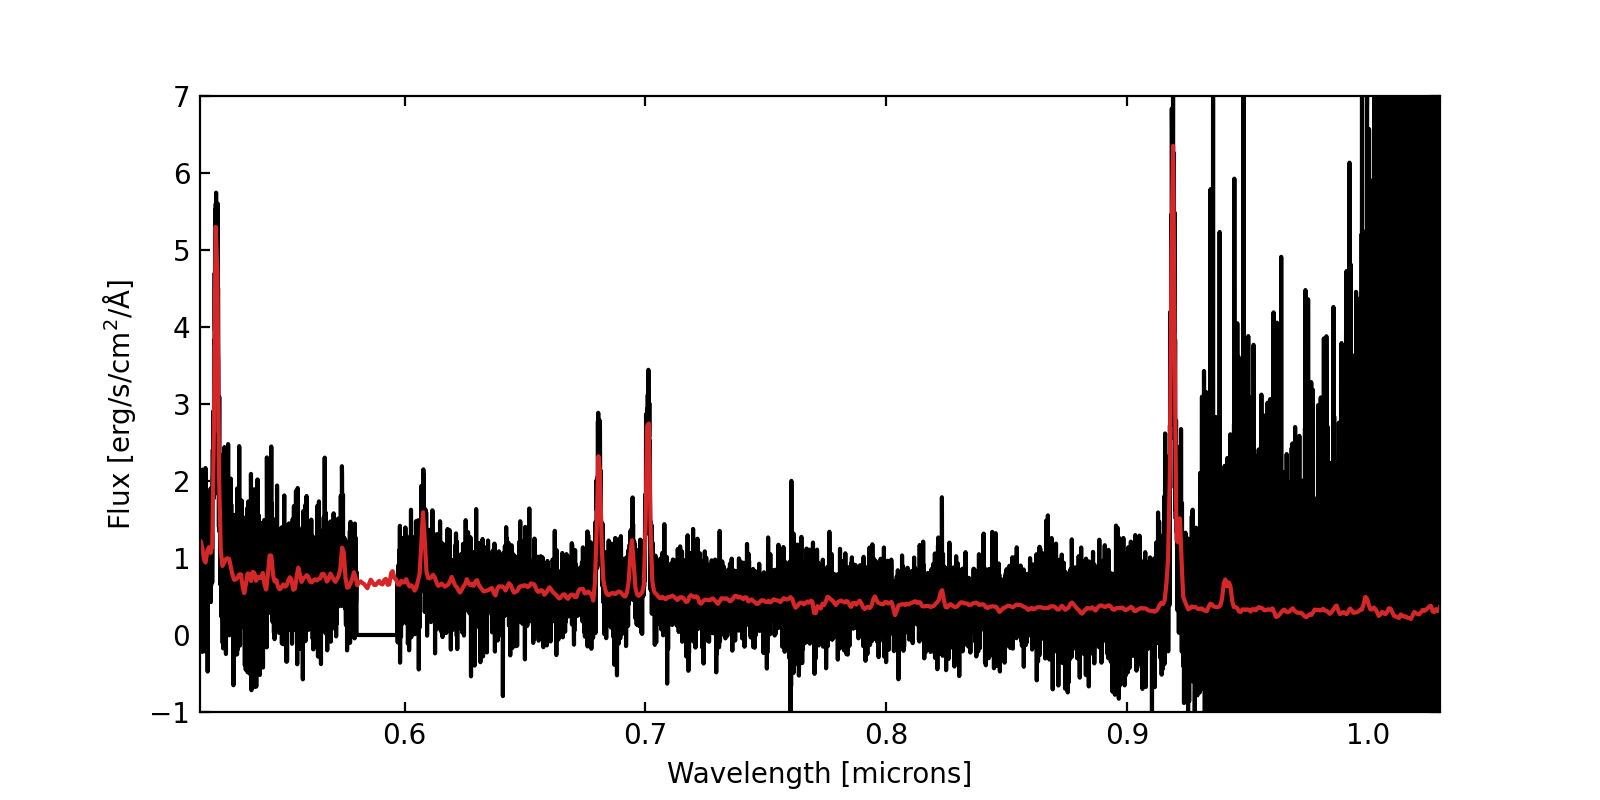

In [5]:
#set up the template
templateSource.set_params(template='Sc', redshift=0.4, obs_mag=19, obs_band='sdss_i', norm='extended')

#set up the IFS
mavis_ifs = MAVIS_IFS(mode='LR-red', pix_scale=0.05)

#generate a mock observations
noisy_template, noiseless_template = mavis_ifs.observe(templateSource, sky=skyModel, dit=1200, ndit=12)

#plot it!
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(mavis_ifs.inst_wavelength, noisy_template/1e-16, color='black')
ax.plot(mavis_ifs.inst_wavelength, noiseless_template/1e-16, color='C3')

#some sensibile axis limits
plt.xlim(mavis_ifs.inst_wavelength.min(), mavis_ifs.inst_wavelength.max())
plt.ylim(-1, 7) #10^-16 erg/s/cm^2/A

#labels
plt.xlabel('Wavelength [microns]')
plt.ylabel('Flux [erg/s/cm$^{2}$/$\mathrm{\AA}$]')
plt.show()

4) Exposure time estimates for a compact (point source) ETG at z=0.8

In [6]:
#set up the template
templateSource.set_params(template='E', redshift=0.8, obs_mag=25, obs_band='sdss_i', norm='point')

#set up the IFS
mavis_ifs = MAVIS_IFS(mode='LR-red', pix_scale=0.05)

#number of 1200s exposures to reach S/N of at least 5 near redshifted Hbeta
_,_ = mavis_ifs.calc_sn(templateSource, sky=skyModel, dit=1200., sn=5, ref_wl=4855.5*1.8/1e4)

#S/N near Hbeta given 10 x 600s exposures
_,_ = mavis_ifs.calc_sn(templateSource, sky=skyModel, dit=600., ndit=10, ref_wl=4855.5*1.8/1e4)

NDIT=10 to reach S/N=5 with DIT=1200.0s at 0.8740um
S/N=0.86 at 0.8740um with NDIT=10 and DIT=600.0


## Imager

1) Limiting magnitudes for standard broadband filters

<IPython.core.display.Javascript object>


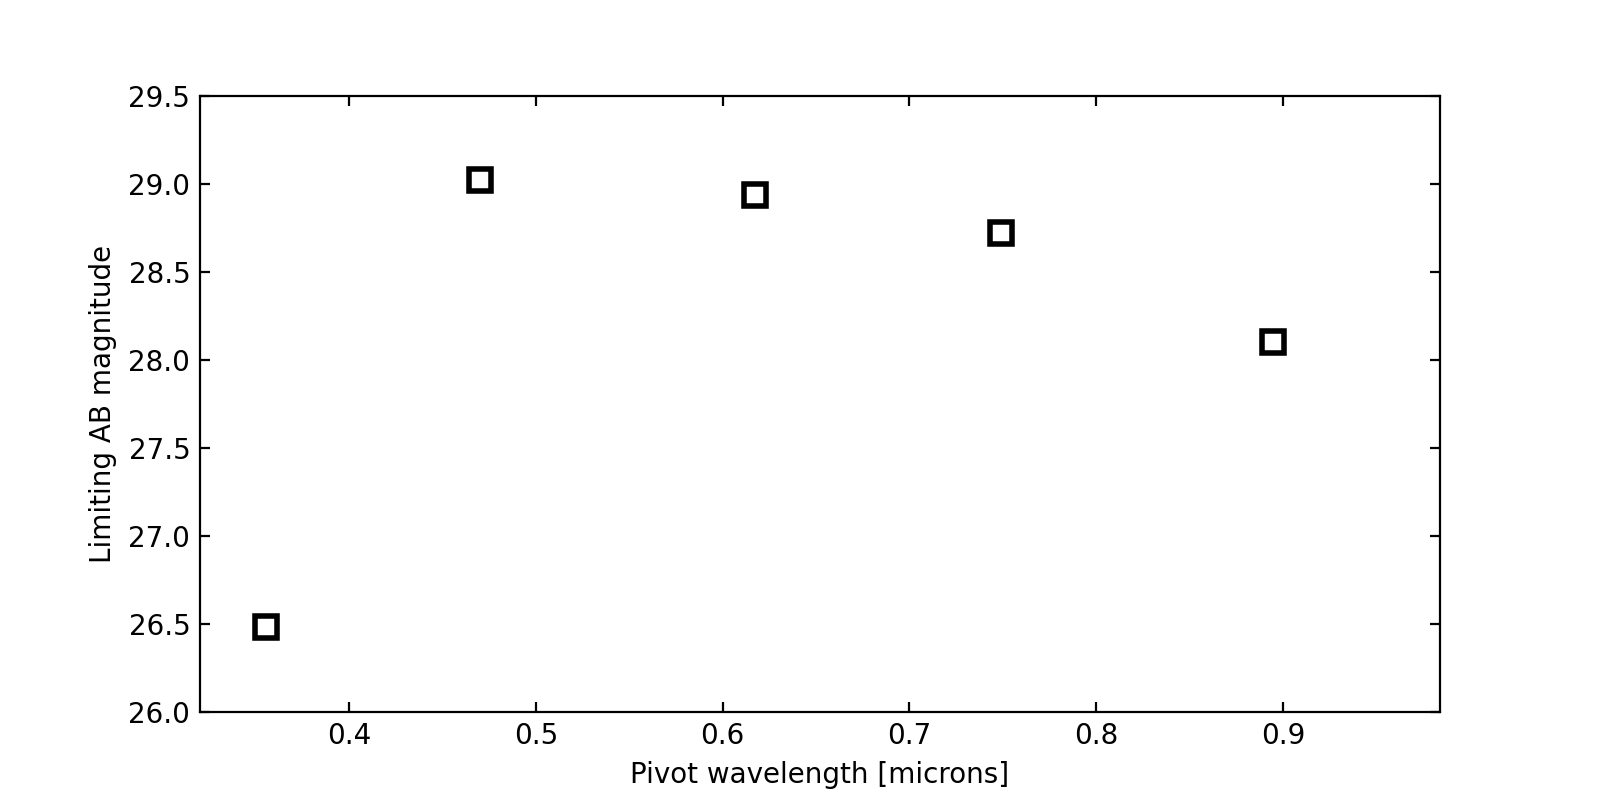

In [7]:
#initialize the imager
mavis_imager = MAVIS_Imager()

#assume 3 x 1200s exposures, 3x3 binning
pivots, limits = mavis_imager.get_mag_limit(sn=10, sky=skyModel, dit=1200, ndit=3, 
                                            band=['sdss_u', 'sdss_g', 'sdss_r', 'sdss_i', 'sdss_z'], 
                                            norm='point', binning=3)

#plot it!
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(pivots, limits, 's', mfc='white', mec='black', mew=2, ms=8)

#some sensibile axis limits
plt.xlim(0.9*min(pivots), 1.1*max(pivots))
plt.ylim(26., 29.5) 

#labels
plt.xlabel('Pivot wavelength [microns]')
plt.ylabel('Limiting AB magnitude')
plt.show()

2) Limiting magnitudes for narroband filters with varying tip-tilt performance

<IPython.core.display.Javascript object>


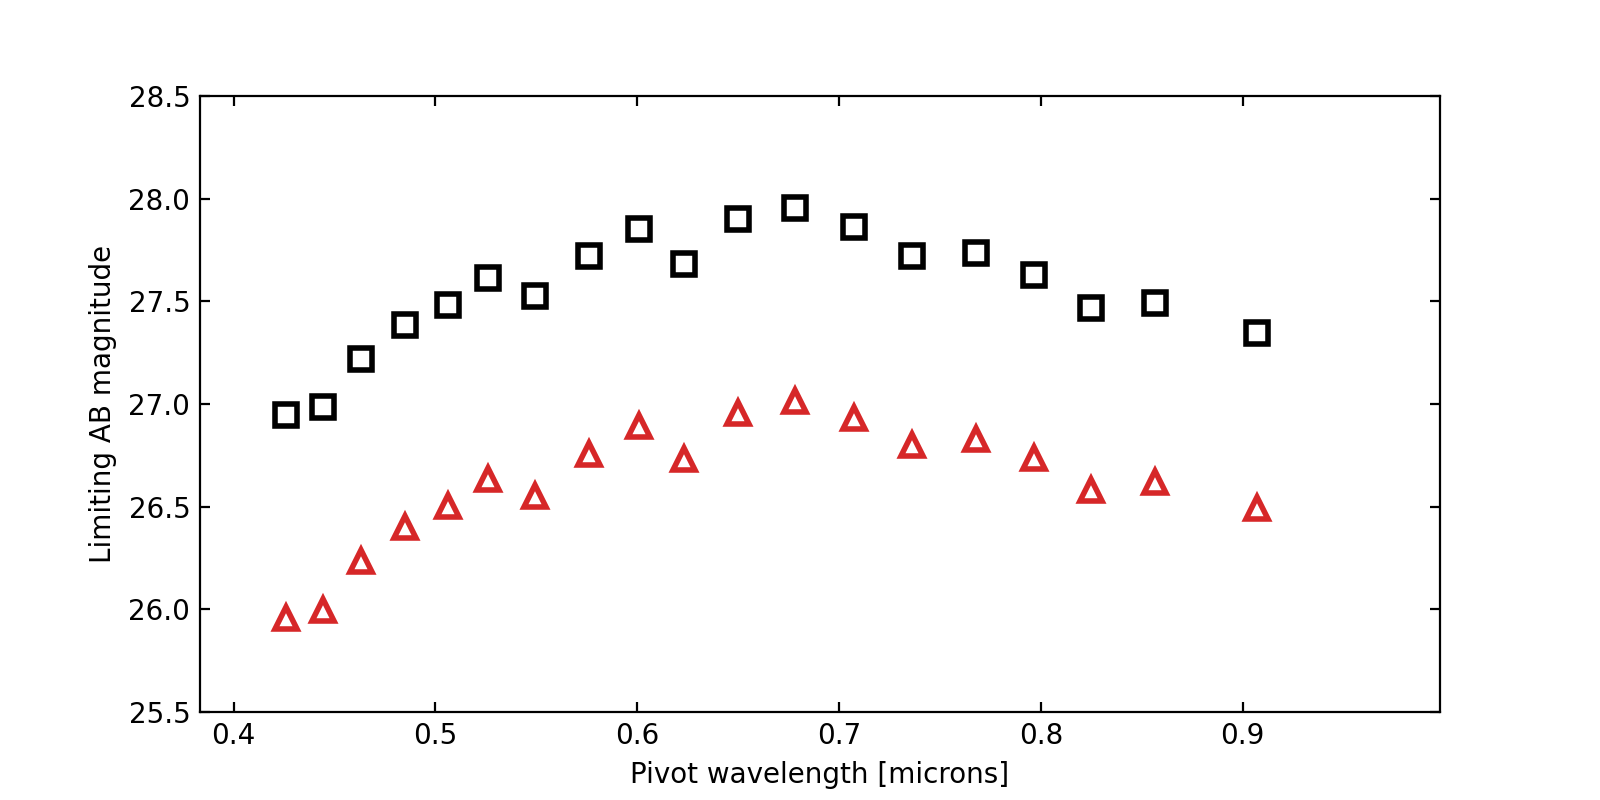

In [8]:
#initialize the imager
mavis_imager = MAVIS_Imager()
mavis_imager_tt = MAVIS_Imager(jitter=20) #test a case with 20mas jitter (c.f. 5)

#bands
many_bands = ['suprimecam_ia427','suprimecam_ia445',
              'suprimecam_ia464','suprimecam_ia484',
              'suprimecam_ia505','suprimecam_ia527',
              'suprimecam_ia550','suprimecam_ia574',
              'suprimecam_ia598','suprimecam_ia624',
              'suprimecam_ia651','suprimecam_ia679',
              'suprimecam_ia709','suprimecam_ia738',
              'suprimecam_ia767','suprimecam_ia797',
              'suprimecam_ia827','suprimecam_ia856',
              'suprimecam_ia907']

#assume 6 x 600s exposures, 3x3 binning
pivots, limits = mavis_imager.get_mag_limit(sn=10, sky=skyModel, dit=600, ndit=6, 
                                            band=many_bands, norm='point', binning=3)

#compare with poorer tip-tilt performance
pivots_tt, limits_tt = mavis_imager_tt.get_mag_limit(sn=10, sky=skyModel, dit=600, ndit=6, 
                                                           band=many_bands, norm='point', binning=3)

#plot it!
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(pivots, limits, 's', mfc='white', mec='black', mew=2, ms=8)
ax.plot(pivots_tt, limits_tt, '^', mfc='white', mec='C3', mew=2, ms=8)

#some sensibile axis limits
plt.xlim(0.9*min(pivots), 1.1*max(pivots))
plt.ylim(25.5, 28.5) 

#labels
plt.xlabel('Pivot wavelength [microns]')
plt.ylabel('Limiting AB magnitude')
plt.show()

3) What about swapping out detectors

<IPython.core.display.Javascript object>


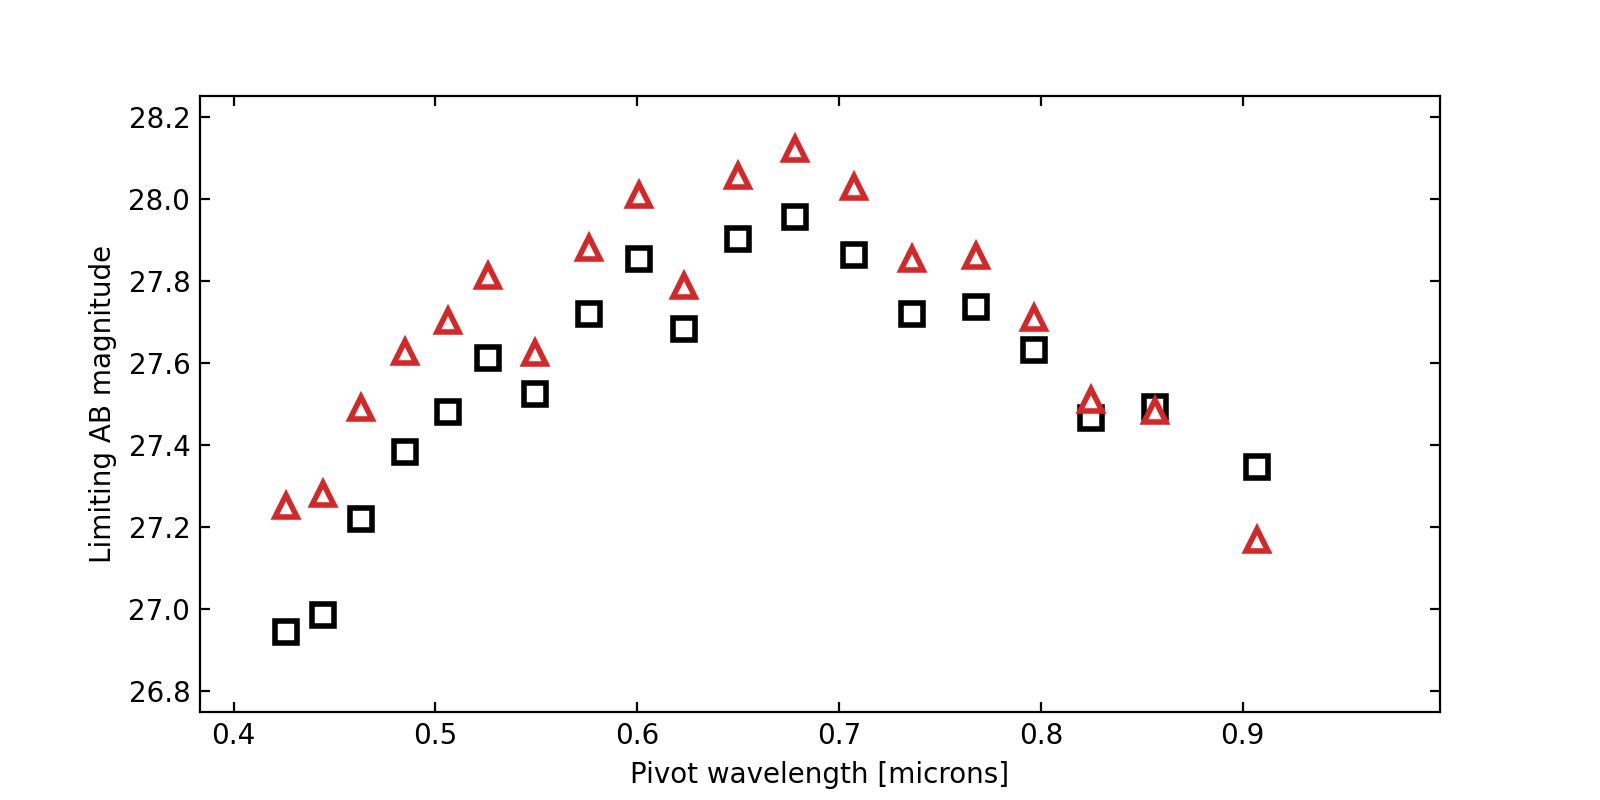

In [9]:
#initialize the imager
mavis_imager = MAVIS_Imager()

#swap out for the CCD290
from mavisetc.detectors import CCD290
mavis_imager_290 = MAVIS_Imager(detector=CCD290) 

#bands
many_bands = ['suprimecam_ia427','suprimecam_ia445',
              'suprimecam_ia464','suprimecam_ia484',
              'suprimecam_ia505','suprimecam_ia527',
              'suprimecam_ia550','suprimecam_ia574',
              'suprimecam_ia598','suprimecam_ia624',
              'suprimecam_ia651','suprimecam_ia679',
              'suprimecam_ia709','suprimecam_ia738',
              'suprimecam_ia767','suprimecam_ia797',
              'suprimecam_ia827','suprimecam_ia856',
              'suprimecam_ia907']

#assume 3 x 1200s exposures, 3x3 binning
pivots, limits = mavis_imager.get_mag_limit(sn=10, sky=skyModel, dit=600, ndit=6, 
                                            band=many_bands, norm='point', binning=3)

#compare with the CCD290. Assume lower CR rate and longer exposure
pivots_290, limits_290 = mavis_imager_290.get_mag_limit(sn=10, sky=skyModel, dit=1200, ndit=3, 
                                                           band=many_bands, norm='point', binning=3)

#plot it!
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(pivots, limits, 's', mfc='white', mec='black', mew=2, ms=8)
ax.plot(pivots_290, limits_290, '^', mfc='white', mec='C3', mew=2, ms=8)

#some sensibile axis limits
plt.xlim(0.9*min(pivots), 1.1*max(pivots))
plt.ylim(26.75, 28.25) 

#labels
plt.xlabel('Pivot wavelength [microns]')
plt.ylabel('Limiting AB magnitude')
plt.show()

4) Imaging exposure times for a compact (point source) ETG at z=0.8

In [11]:
#set up the template
templateSource.set_params(template='E', redshift=0.8, obs_mag=28, obs_band='sdss_i', norm='point')

#initialize the imager
mavis_imager = MAVIS_Imager()

#number of 600s exposures to reach S/N of at least 10 
mavis_imager.calc_sn(templateSource, sky=skyModel, dit=600., band=['sdss_g','sdss_r','sdss_i','sdss_z'], sn=10)

#S/N given 10 x 300s exposures
mavis_imager.calc_sn(templateSource, sky=skyModel, dit=300., ndit=10, band=['sdss_g','sdss_r','sdss_i','sdss_z'])

NDIT=19 to reach S/N=10 with DIT=600.0 in sdss_g
NDIT=4 to reach S/N=10 with DIT=600.0 in sdss_r
NDIT=2 to reach S/N=10 with DIT=600.0 in sdss_i
NDIT=2 to reach S/N=10 with DIT=600.0 in sdss_z
S/N=0.99 at with NDIT=10 and DIT=300.0 in sdss_g
S/N=6.67 at with NDIT=10 and DIT=300.0 in sdss_r
S/N=14.09 at with NDIT=10 and DIT=300.0 in sdss_i
S/N=18.56 at with NDIT=10 and DIT=300.0 in sdss_z
